In [4]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

original = np.genfromtxt("../로그 데이터/SEG_SGEMM_result.txt", delimiter="\n", dtype=np.int64).reshape(-1, 1)
original = pd.DataFrame(data=original, columns=["SEG"])
data = original.copy()
original

,SEG
0,3196231680
1,93292771632
2,93293300344
3,93293373376
4,93292057424
...,...
237191,92622695528
237192,92622695520
237193,92658792872
237194,92658792864


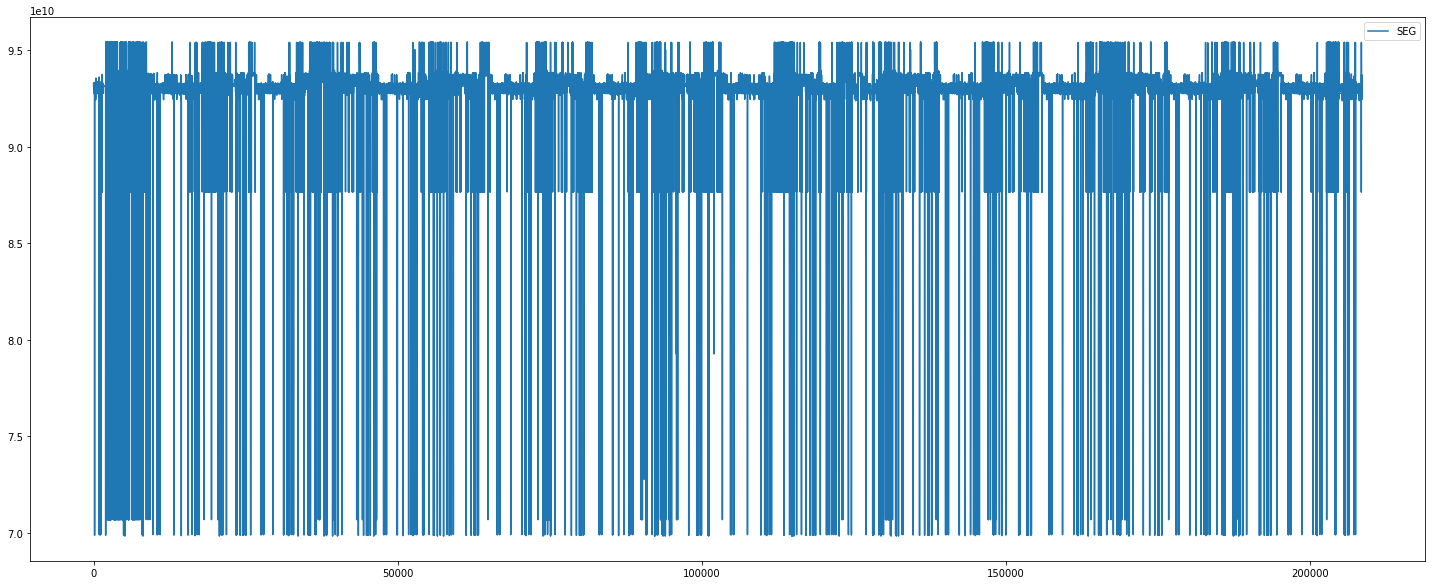

In [6]:
value_range = [(data["SEG"].max() - data["SEG"].min()) / 10 *i for i in range(10)]
docile = (data["SEG"] <= value_range[1])     # Only Remove 1st chunk of deciles
docile_index = docile.index[docile == True]

data = data.drop(index=docile_index)
data = data[28000:].reset_index(drop=True)
data.plot(figsize=(25, 10))

In [7]:
len(data)

208501

In [8]:
def delta_slice(data, step, cutoff=None):
    if cutoff:
        data = data[cutoff:].reset_index(drop=True)
    delta = pd.DataFrame(data=[data.loc[i+step] - data.loc[i] for i in range(int(len(data))-step)])
    return delta

In [9]:
pattern_length = 4

delta = delta_slice(data, pattern_length)
delta

,SEG
0,432584
1,-21321705
2,-56053462
3,87057360
4,-101953016
...,...
208492,29537720
208493,11427864
208494,47525224
208495,-75277398


In [10]:
split_index = 190000
train_set = delta[:split_index]
test_set = delta[split_index:]
test_set.reset_index(drop=True, inplace=True)
train_set, test_set

(              SEG
 0          432584
 1       -21321705
 2       -56053462
 3        87057360
 4      -101953016
 ...           ...
 189995    8497752
 189996    4514130
 189997    4938572
 189998   -8385412
 189999    6033432
 
 [190000 rows x 1 columns],
             SEG
 0       2985022
 1      -9098444
 2       7605476
 3      -8908504
 4      44216784
 ...         ...
 18492  29537720
 18493  11427864
 18494  47525224
 18495 -75277398
 18496  32291664
 
 [18497 rows x 1 columns])

In [12]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

train_data_scaled = minmax_scaler.fit_transform(train_set.values)
train_data_scaled

array([[0.5000118 ],
       [0.49958683],
       [0.49890836],
       ...,
       [0.50009982],
       [0.49983954],
       [0.50012121]])

In [16]:
def generate_timeseries(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i:i+target_size])
    return np.array(data), np.array(labels)

In [17]:
PAST_HISTORY = 16
FUTURE_TARGET = 8
TRAIN_SPLIT = 170000
BATCH_SIZE = 256
BUFFER_SIZE = 200000

In [50]:
x_train, y_train = generate_timeseries(train_data_scaled, 0, TRAIN_SPLIT, PAST_HISTORY, FUTURE_TARGET)
x_val, y_val = generate_timeseries(train_data_scaled, TRAIN_SPLIT, None, PAST_HISTORY, FUTURE_TARGET)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).repeat()
val_data = val_data.cache().batch(BATCH_SIZE)

In [34]:
test_data_scaled = minmax_scaler.transform(test_set)
x_test, y_test = generate_timeseries(test_data_scaled, 0, None, PAST_HISTORY, FUTURE_TARGET)

In [29]:
hyper_params = {
    "num_neurons_1" : [32, 64, 128]
    "num_neurons_2" : [32, 64, 128]
    "dropout_rates" : [0.2, 0.5]
    "epochs" : [250, 500, 1000]
    "activation_functions" : ["relu"]
}
EVALUATION_INTERVAL = 500
VAL_STEPS = 50

In [22]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [24]:
import joblib

joblib.dump(minmax_scaler, "scaler/{0}.pkl".format(timestamp))

['scaler/20200715-165435.pkl']

In [46]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_LSTM_1_UNITS = hp.HParam("num_LSTM_1_units", hp.Discrete([32, 64, 128]))
HP_NUM_LSTM_2_UNITS = hp.HParam("num_LSTM_2_units", hp.Discrete([32, 64, 128]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.1, 0.5))

METRIC_ACCURACY = 'mae'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_LSTM_1_units, HP_NUM_LSTM_2_units, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='mae')]
    )

In [52]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(hparams[HP_NUM_LSTM_1_UNITS], return_sequences=True, input_shape=x_train.shape[-2:]),
        tf.keras.layers.LSTM(hparams[HP_NUM_LSTM_2_UNITS]),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(FUTURE_TARGET),
        tf.keras.layers.Activation("relu")
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(train_data, epochs=1, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=VAL_STEPS)
    _, mae = model.evaluate(x_test, y_test)
    return model

In [53]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [54]:
session_num = 0

for num_LSTM_1_units in HP_NUM_LSTM_1_UNITS.domain.values:
    for num_LSTM_2_units in HP_NUM_LSTM_2_UNITS.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                hparams = {
                    HP_NUM_LSTM_1_UNITS: num_LSTM_1_units,
                    HP_NUM_LSTM_2_UNITS: num_LSTM_2_units,
                    HP_DROPOUT: dropout_rate
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1

--- Starting trial: run-0
{'num_LSTM_1_units': 32, 'num_LSTM_2_units': 32, 'dropout': 0.1}
578/578 [==============================] - 1s 2ms/step - loss: 0.0022 - mae: 0.0134


ValueError: Attempt to convert a value (<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001DBB0A25048>) with an unsupported type (<class 'tensorflow.python.keras.engine.sequential.Sequential'>) to a Tensor.

In [18]:
log_dir = "logs/fit/" + timestamp
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=VAL_STEPS, callbacks=[tensorboard_callback])

Epoch 1/1000
109/500 [=====>........................] - ETA: 2s - loss: 0.0258 - mse: 0.0258 - mae: 0.0994

KeyboardInterrupt: 

In [35]:
model.save("models/{0}.h5".format(title))

In [36]:
new_model = keras.models.load_model("models/{0}.h5".format(title))
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 16, 128)           66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
Total params: 199,176
Trainable params: 199,176
Non-trainable params: 0
_________________________________________________________________


In [39]:
test_data = delta_slice(test_set, pattern_length)
test_data_nomalized = minmax_scaler.transform(test_data)
x_test, y_test = generate_timeseries(test_data_nomalized, 0, None, PAST_HISTORY, FUTURE_TARGET)

In [44]:
predict_train = new_model.predict(x_test[0].reshape(1, -1, 1))
minmax_scaler.inverse_transform(predict_train)

array([[-3.1946584e+07, -1.9103973e+08,  2.9404096e+07, -8.2782800e+07,
        -4.6914292e+07,  1.6672381e+08,  9.4962392e+07, -2.3673228e+07]],
      dtype=float32)

In [41]:
from sklearn.metrics import mean_squared_error

def plot_test_error(model, x_test, y_test, title=None):
    test_preds = []
    test_errors = []
    for x, y in zip(x_test, y_test):
        x_pred = model.predict(x.reshape(1, -1, 1))
        test_preds.append(x_pred)
        test_errors.append(mean_squared_error(y.reshape(1, -1), x_pred))
    test_errors = pd.DataFrame(data=[test_errors]).T
    test_errors.columns = ["Test MSE"]
    test_plot = test_errors.plot(figsize=(25, 10))
    test_plot.set_ylim(0, 0.04)
    if title:
        test_errors.to_csv("result/test_mse-{0}.csv".format(title), index=False)
        test_plot.figure.savefig("result/test_mse-{0}.png".format(title), dpi=300)
    plt.show()
    return test_preds, test_errors

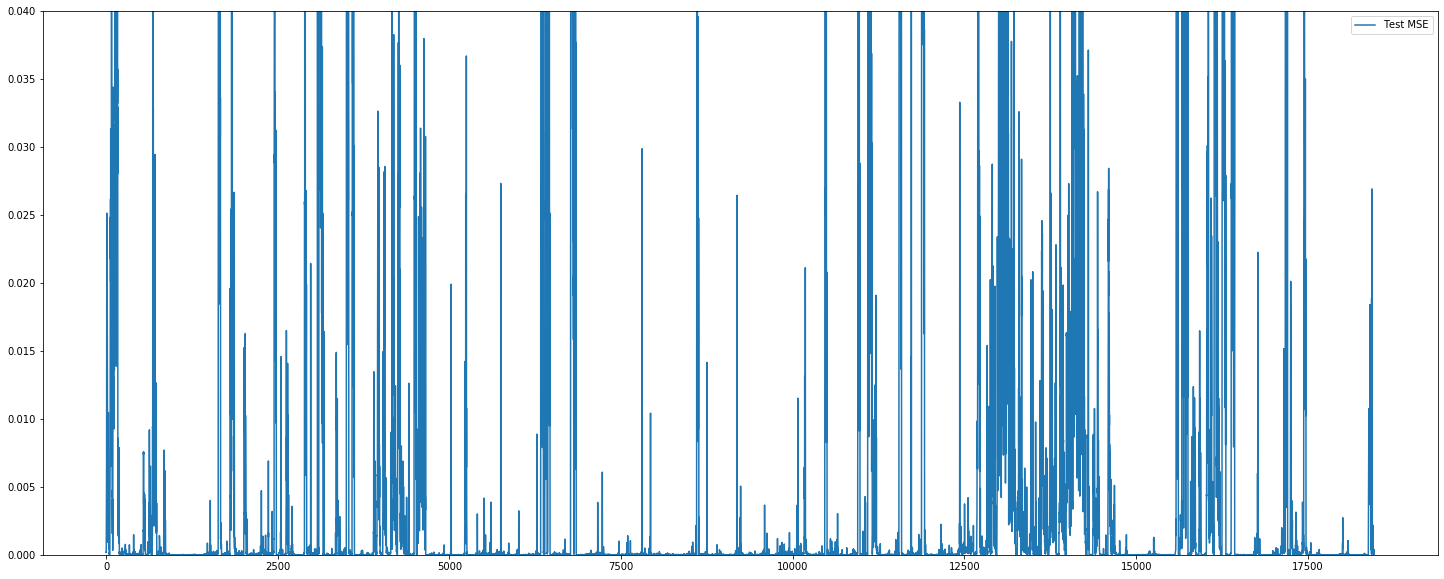

In [42]:
test_preds, test_errors = plot_test_error(model, x_test, y_test, title)

In [45]:
test_result = pd.read_csv("result/test_mse-{}.csv".format(title))
test_result

,Test MSE
0,0.000191
1,0.000206
2,0.000187
3,0.001499
4,0.002733
...,...
18464,0.000020
18465,0.000383
18466,0.000165
18467,0.000031


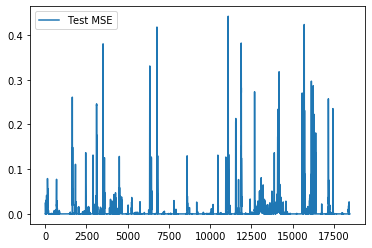

In [46]:
test_result.plot()

In [47]:
test_result.describe()

,Test MSE
count,1.846900e+04
mean,5.761784e-03
std,2.569363e-02
min,2.356425e-07
25%,5.663350e-06
50%,3.298850e-05
75%,2.488477e-04
max,4.417106e-01


In [194]:
minmax_scaler.data_min_, minmax_scaler.data_max_

(array([-2.5595576e+10]), array([2.55952335e+10]))

In [127]:
sample = data.loc[190000:190100].copy().reset_index(drop=True)
sample

,SEG
0,93240709890
1,93249283372
2,93236195868
3,93252603624
4,93243694912
...,...
96,87646500800
97,87648758448
98,87650635040
99,87648769168


In [143]:
sample_delta = delta_slice(sample, pattern_length)
check_0 = sample.loc[4] - sample.loc[0]
check_23 = sample.loc[27] - sample.loc[23]
sample_delta[:24], check_0, check_23

(          SEG
 0     2985022
 1    -9098444
 2     7605476
 3    -8908504
 4    44216784
 5    54725728
 6     6871072
 7   -57360544
 8     7281952
 9   -58086888
 10   44513296
 11  108851344
 12 -106765680
 13    7699336
 14  452792720
 15  -57081978
 16   49647494
 17   50610416
 18 -458615584
 19   25133414
 20  -10666118
 21  459763376
 22  383078224
 23  409206686,
 SEG    2985022
 dtype: int64,
 SEG    409206686
 dtype: int64)

In [145]:
sample_scaled = minmax_scaler.transform(sample_delta)
sample_scaled[:24], minmax_scaler.transform([check_0]), minmax_scaler.transform([check_23])

(array([[0.50006166],
        [0.49982561],
        [0.50015192],
        [0.49982932],
        [0.50086711],
        [0.5010724 ],
        [0.50013757],
        [0.49888282],
        [0.5001456 ],
        [0.49886863],
        [0.5008729 ],
        [0.50212973],
        [0.4979177 ],
        [0.50015375],
        [0.50884854],
        [0.49888826],
        [0.5009732 ],
        [0.50099201],
        [0.4910444 ],
        [0.50049432],
        [0.49979499],
        [0.50898471],
        [0.50748669],
        [0.5079971 ]]),
 array([[0.50006166]]),
 array([[0.5079971]]))

In [147]:
x_sample = sample_scaled[:16]
y_sample = sample_scaled[16:24]
x_sample, y_sample

(array([[0.50006166],
        [0.49982561],
        [0.50015192],
        [0.49982932],
        [0.50086711],
        [0.5010724 ],
        [0.50013757],
        [0.49888282],
        [0.5001456 ],
        [0.49886863],
        [0.5008729 ],
        [0.50212973],
        [0.4979177 ],
        [0.50015375],
        [0.50884854],
        [0.49888826]]),
 array([[0.5009732 ],
        [0.50099201],
        [0.4910444 ],
        [0.50049432],
        [0.49979499],
        [0.50898471],
        [0.50748669],
        [0.5079971 ]]))

In [150]:
sample_pred = model.predict(x_sample.reshape(1, -1, 1))
sample_pred

array([[0.4940029 , 0.49450025, 0.49372244, 0.50176615, 0.5091118 ,
        0.50518155, 0.503771  , 0.5000737 ]], dtype=float32)

In [166]:
mean_squared_error(y_sample, sample_pred.T), y_sample, sample_pred.T

(3.4671463487365235e-05,
 array([[0.5009732 ],
        [0.50099201],
        [0.4910444 ],
        [0.50049432],
        [0.49979499],
        [0.50898471],
        [0.50748669],
        [0.5079971 ]]),
 array([[0.4940029 ],
        [0.49450025],
        [0.49372244],
        [0.50176615],
        [0.5091118 ],
        [0.50518155],
        [0.503771  ],
        [0.5000737 ]], dtype=float32))

In [171]:
sample_y_inverse = minmax_scaler.inverse_transform(y_sample).astype(np.int64)
sample_pred_inverse = minmax_scaler.inverse_transform(sample_pred.T).astype(np.int64)
sample_y_inverse, sample_pred_inverse

(array([[  49647493],
        [  50610416],
        [-458615584],
        [  25133414],
        [ -10666118],
        [ 459763375],
        [ 383078223],
        [ 409206685]], dtype=int64),
 array([[-307167232],
        [-281707936],
        [-321524704],
        [  90239120],
        [ 466270240],
        [ 265076512],
        [ 192869616],
        [   3600013]], dtype=int64))

In [189]:
for i in range(8):
    print(sample_pred_inverse[i][0])
    print(sample.loc[16+4+i] - sample.loc[16+i])

-307167232
SEG    49647494
dtype: int64
-281707936
SEG    50610416
dtype: int64
-321524704
SEG   -458615584
dtype: int64
90239120
SEG    25133414
dtype: int64
466270240
SEG   -10666118
dtype: int64
265076512
SEG    459763376
dtype: int64
192869616
SEG    383078224
dtype: int64
3600013
SEG    409206686
dtype: int64


In [193]:
for i in range(8):
    print(sample_y_inverse[i][0])
    print(sample_pred_inverse[i][0])
    print(mean_squared_error(y_sample[i], sample_pred.T[i]))
    print(mean_squared_error(sample_pred_inverse[i], sample_pred_inverse[i]))

49647493
-307167232
4.858493141152747e-05
0.0
50610416
-281707936
4.2142928191252615e-05
0.0
-458615584
-321524704
7.17188020765568e-06
0.0
25133414
90239120
1.6175366786751126e-06
0.0
-10666118
466270240
8.680342778705181e-05
0.0
459763375
265076512
1.446403041796957e-05
0.0
383078223
192869616
1.380626840807187e-05
0.0
409206685
3600013
6.278070479671776e-05
0.0


In [177]:
category = data["SEG"].value_counts().to_frame("counts")
category_sort = category.iloc[(category["counts"])]

,counts
93163522156,384
93240795152,63
93267603520,46
93267609664,43
93265735832,42
...,...
93793146088,1
93370245120,1
92848972688,1
69879952632,1
